# Project Statement

The Film Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

Checking the head of the table:

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Checking the table's structure:

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


Checking for duplicates and missing values:

In [7]:
df_reviews.duplicated().sum()

0

no duplicated rows in our data.

In [8]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

We have 2 rows with missing values which will be removed:

In [9]:
df_reviews = df_reviews.dropna()
df_reviews = df_reviews.reset_index(drop=True)

Descriptive statistics of our data:

In [10]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,4.732900e+04,47329.000000,47329.000000,47329.000000
mean,1989.630882,0.001733,5.998278,2.556292e+04,5.484439,0.498933,6279.826808
std,19.600702,0.041588,1.494289,8.367004e+04,3.473083,0.500004,3605.724280
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


We see our values make sense and it seems like there are no illogical values

plotting correlation matrix:

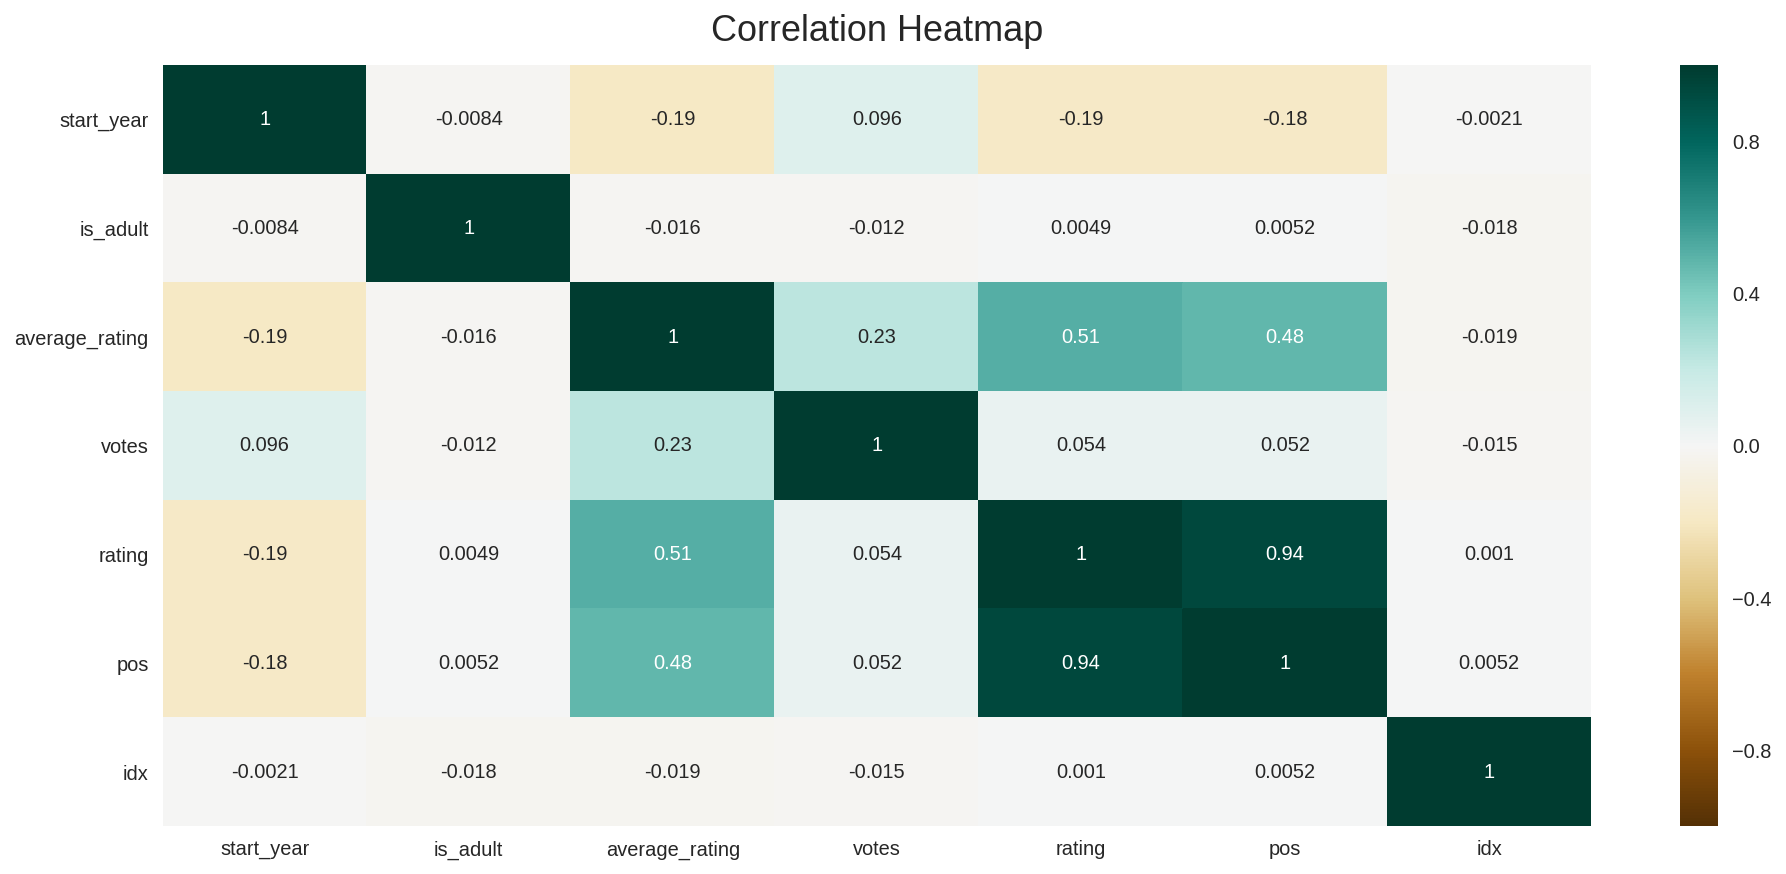

In [11]:
plt.figure(figsize=(16, 7))
heatmap = sns.heatmap(df_reviews.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### Description:
- We can see our rating feature has a very strong positive correlation with our target variable - pos; 0.94.
- we will test our results with and without the rating feature.

## EDA

Let's check the number of movies and reviews over years.

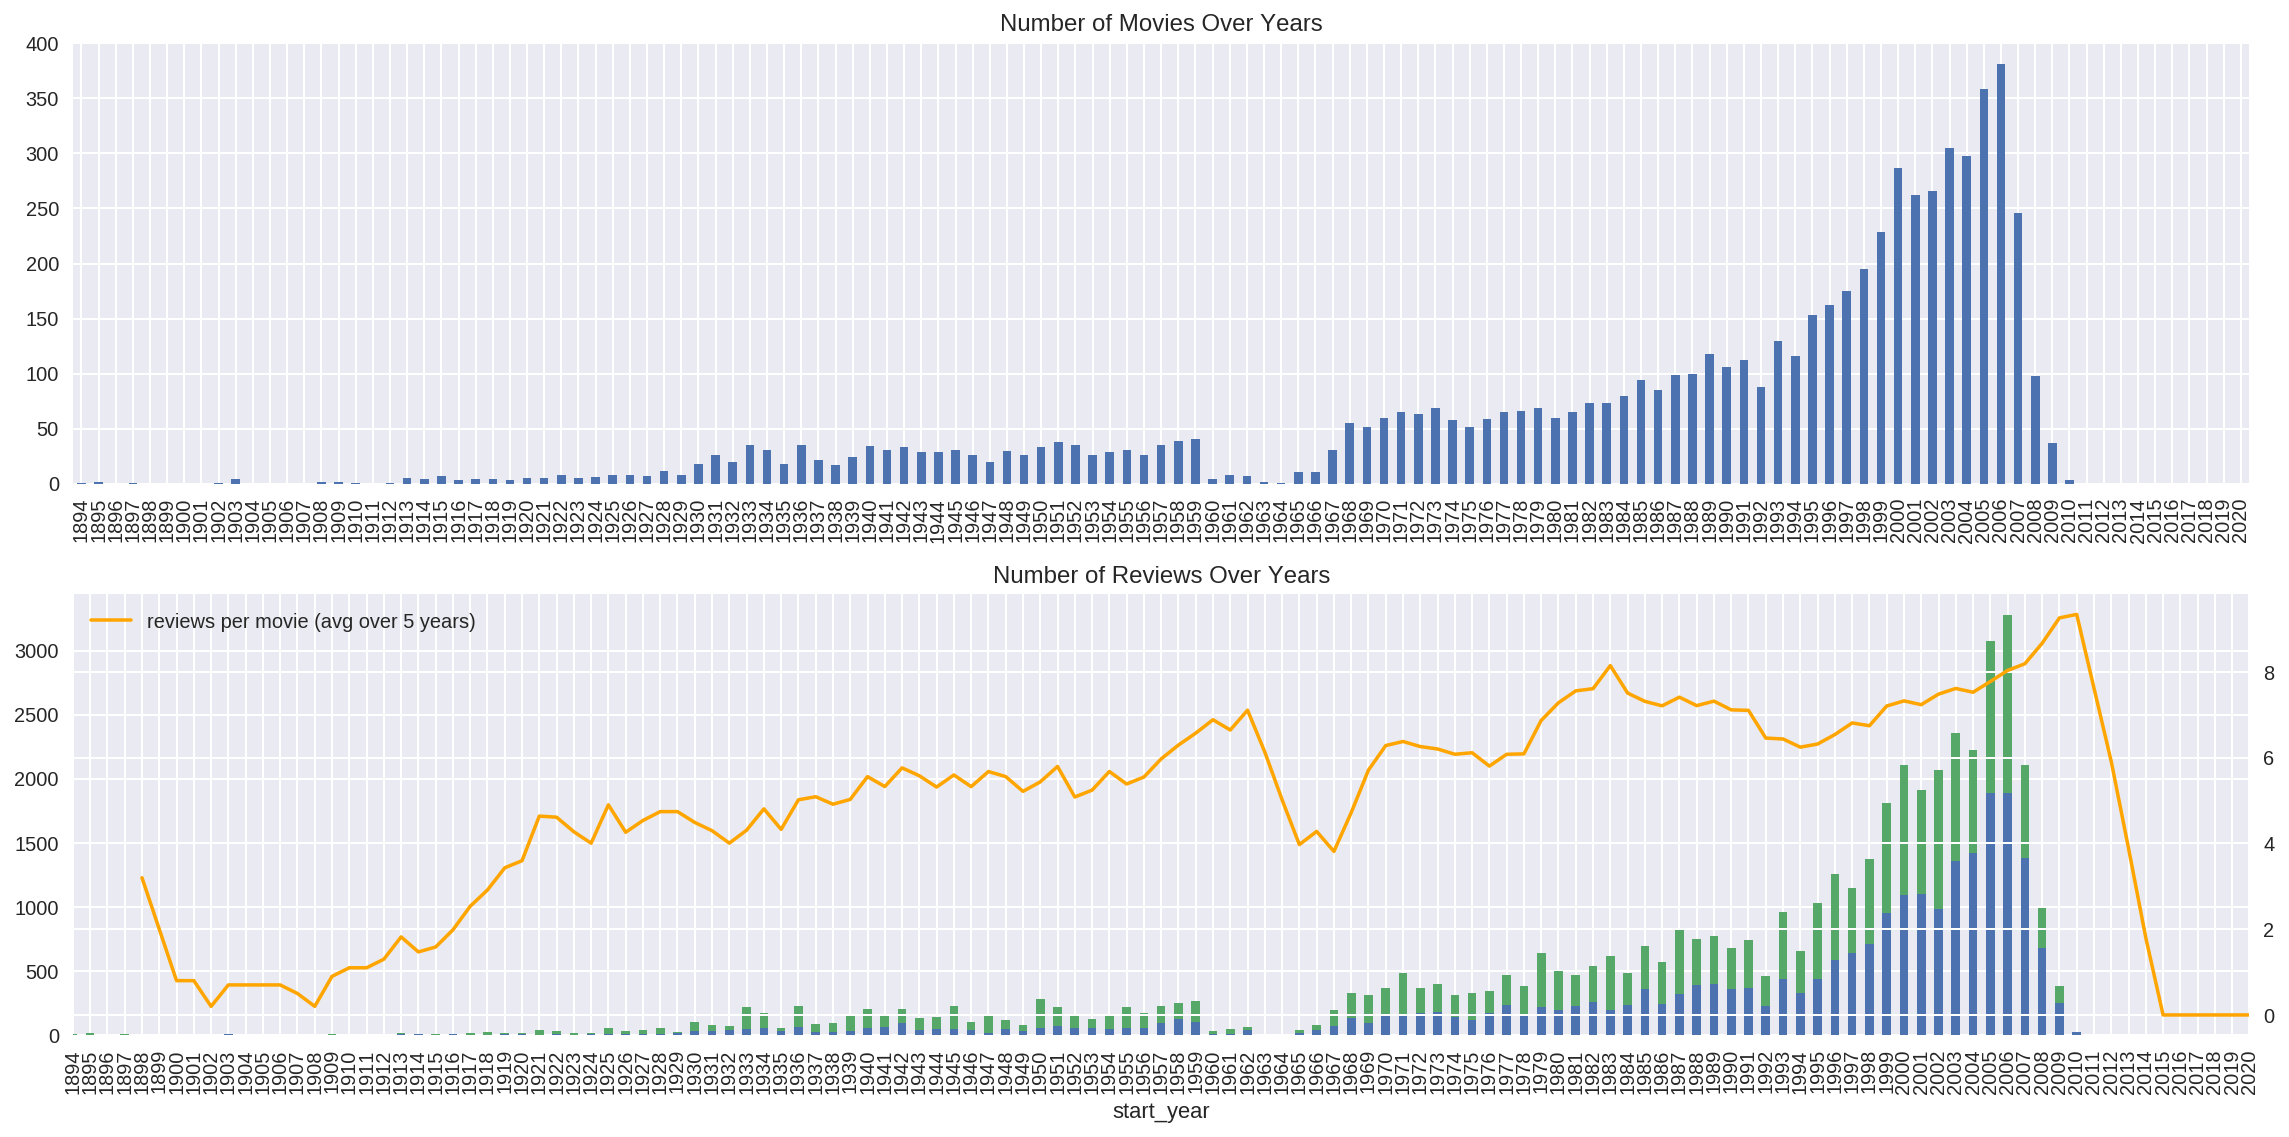

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

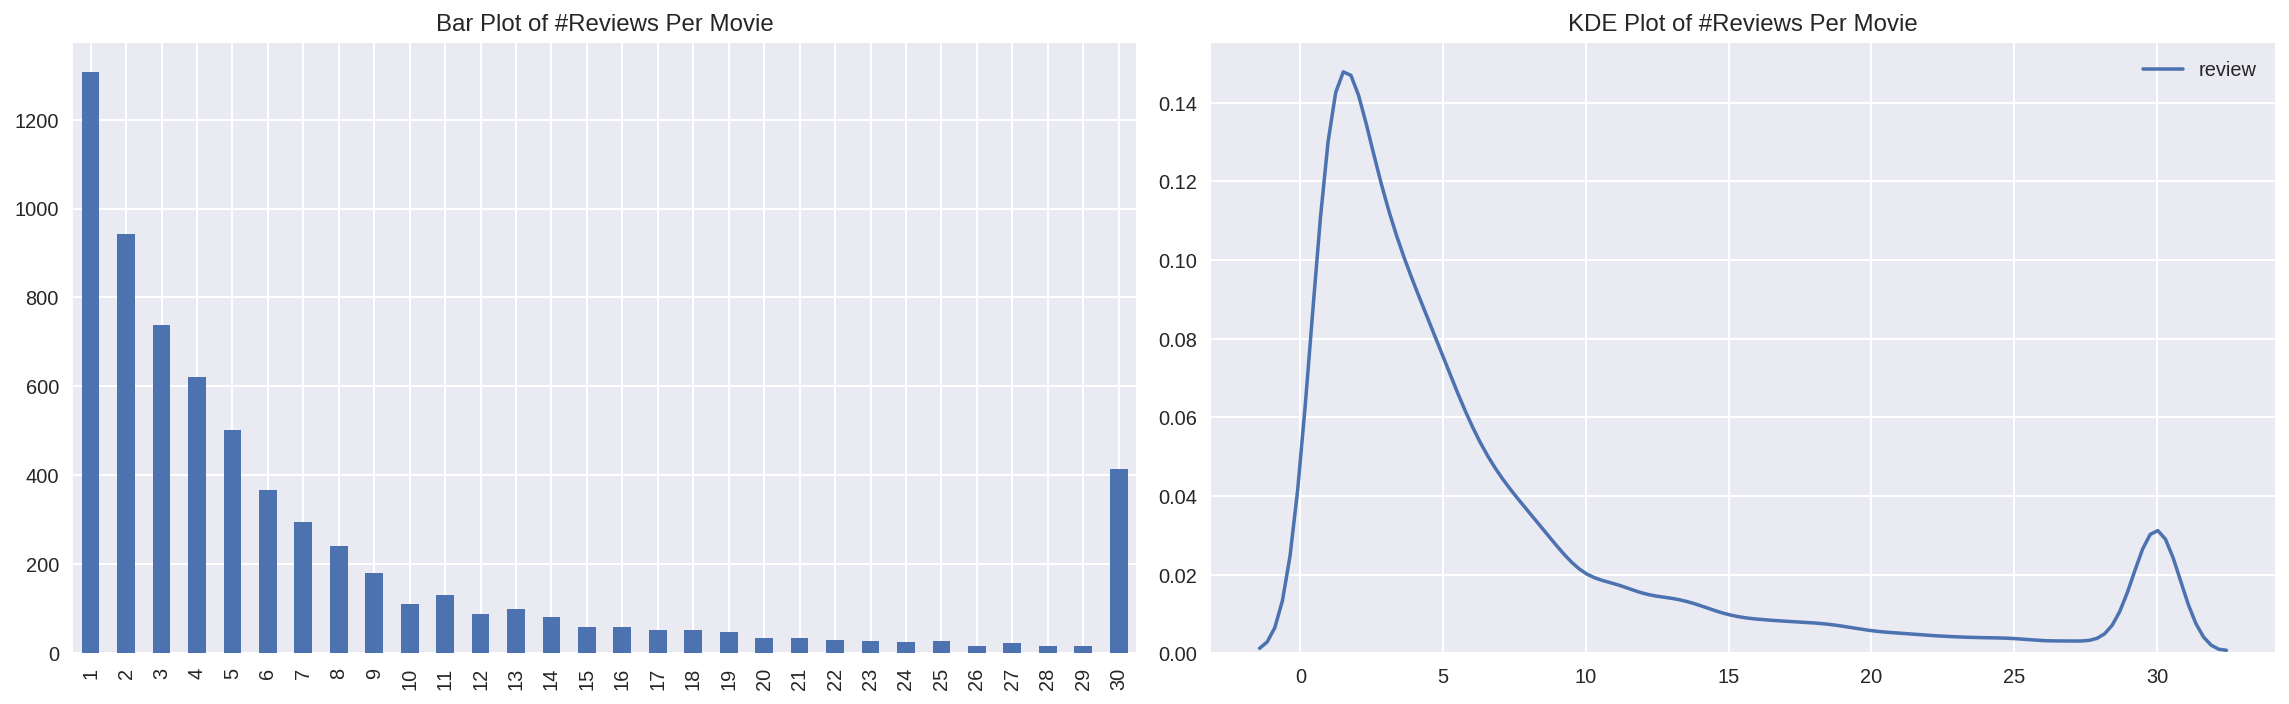

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Checking for class balance:

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

We see our classes are fairly balanced with almost the same amount of observations per class.

Plotting distrubutions of ratings by train and test sets:

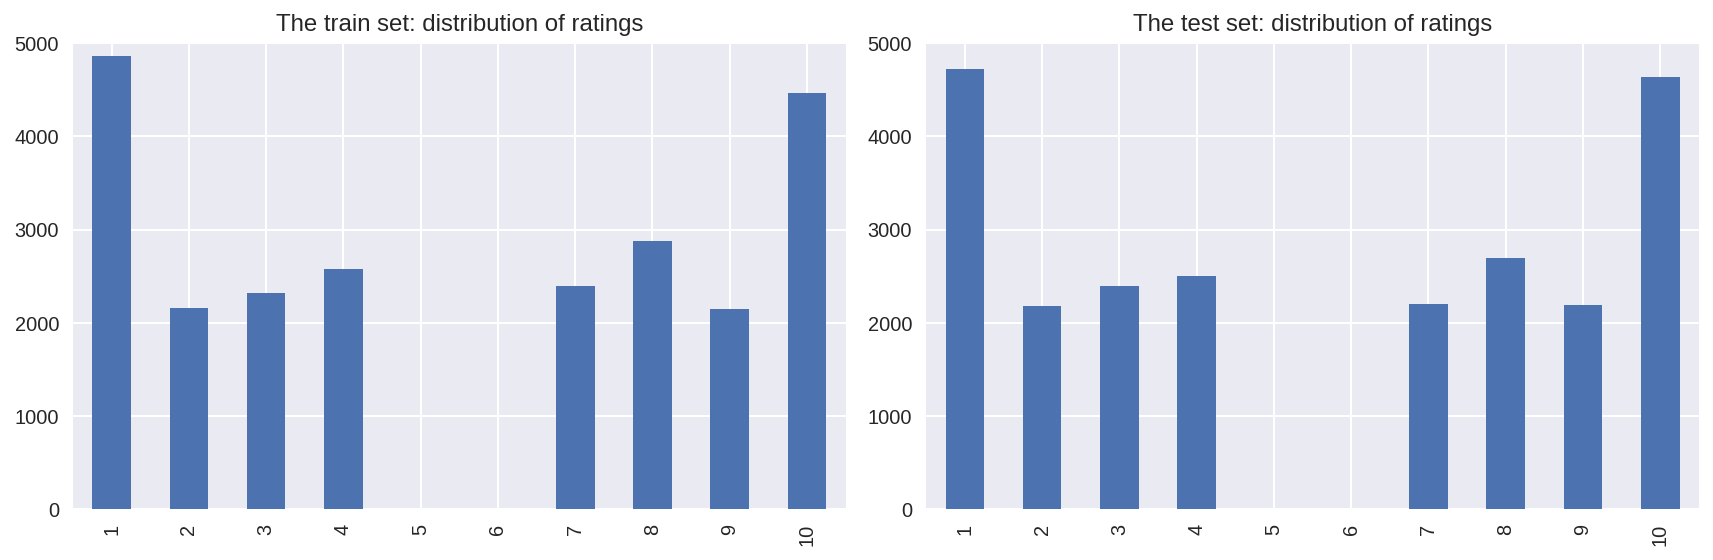

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

We see the distribution is the same between the sets

Distribution of negative and positive reviews over the years for two parts of the dataset

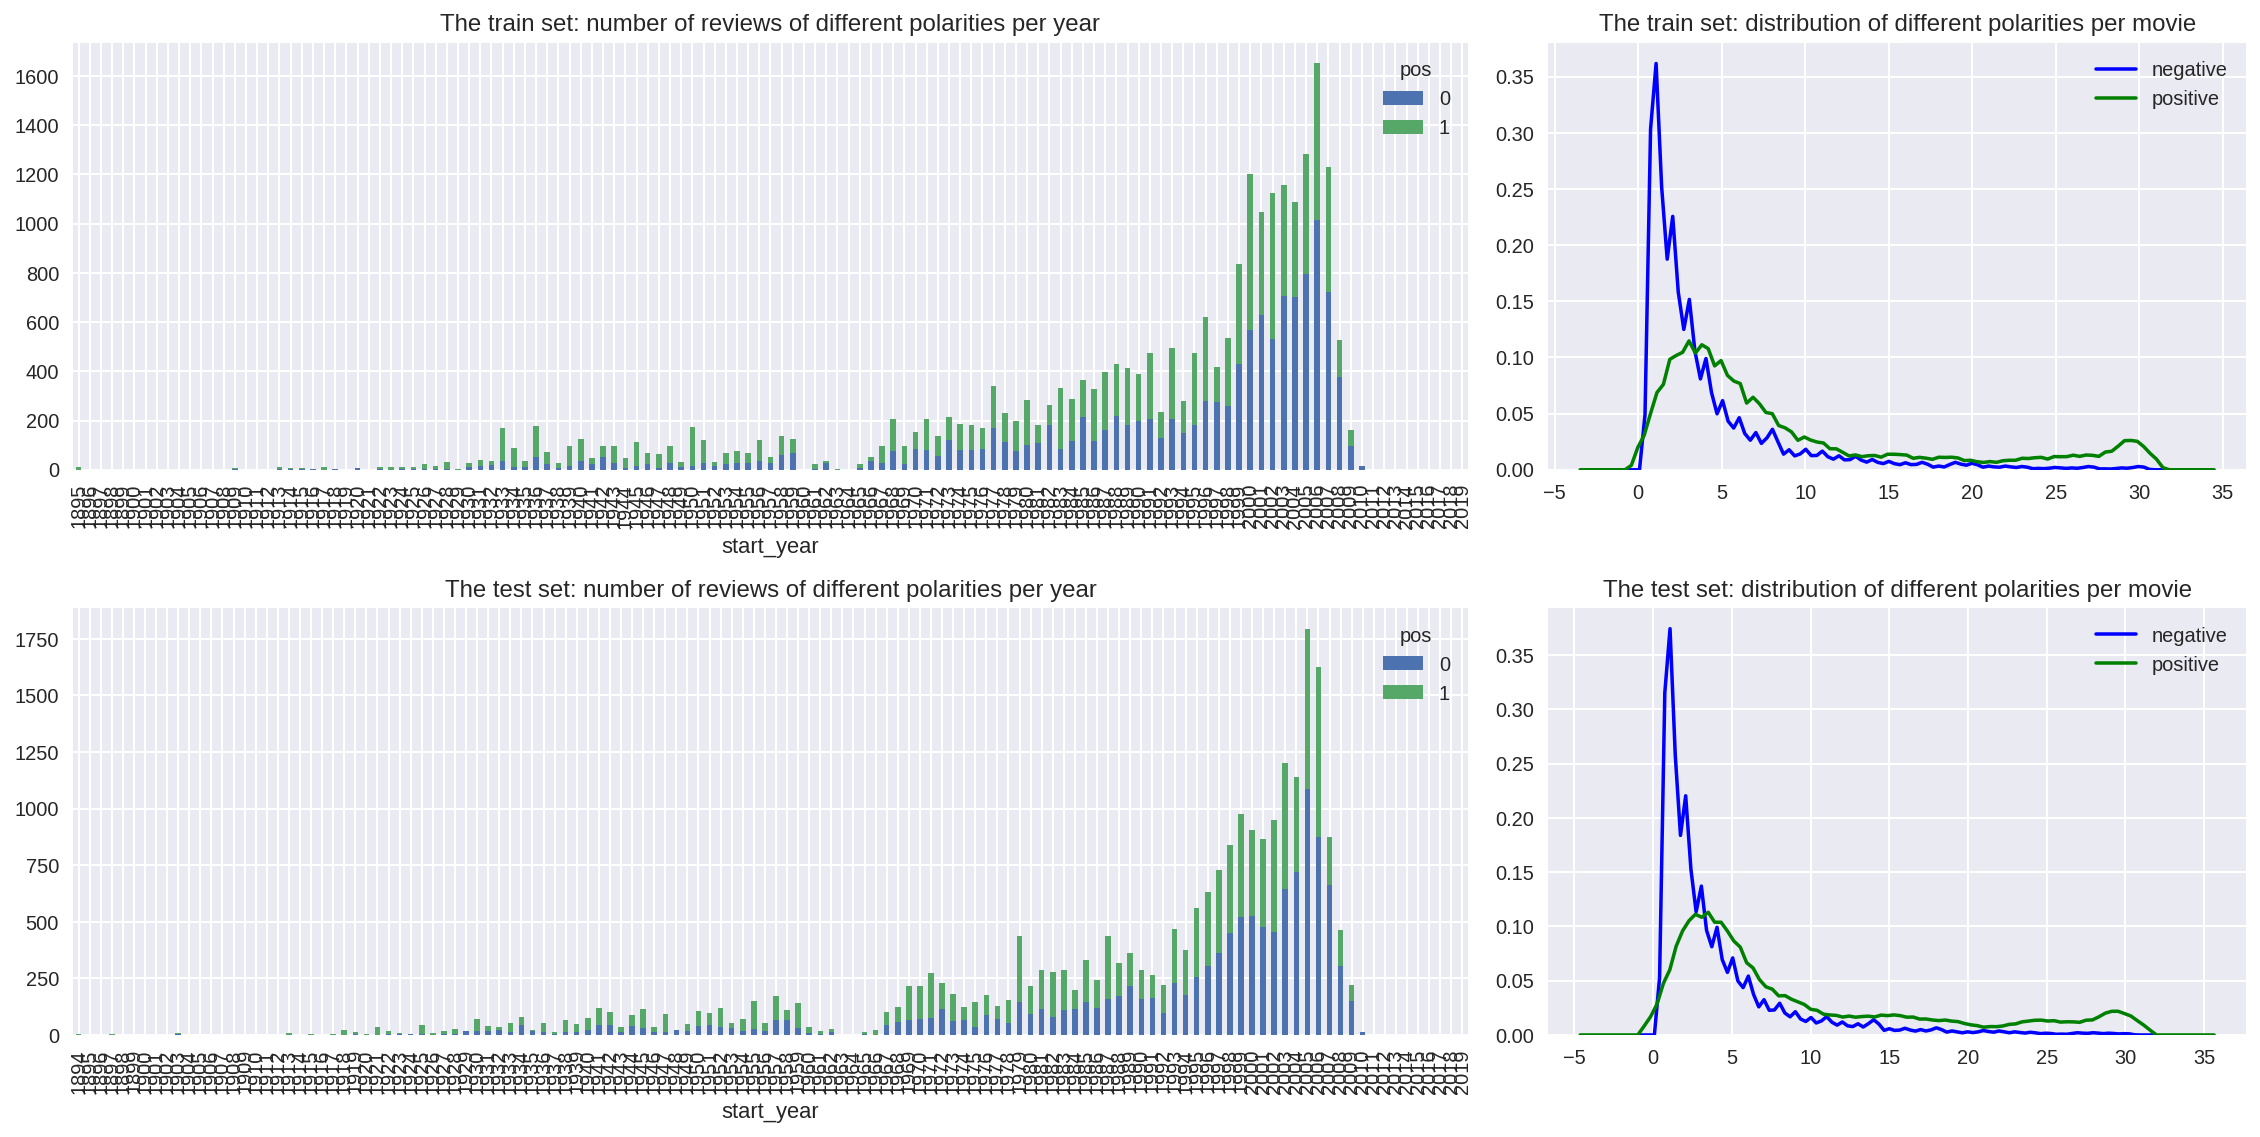

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
def contractions(s): 
    s = re.sub(r"won't", "will not",s)
    s = re.sub(r"would't", "would not",s)
    s = re.sub(r"could't", "could not",s)
    s = re.sub(r"\'d", " would",s)
    s = re.sub(r"can\'t", "can not",s)
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\m", " am", s)
    return s

In [19]:
%%time 

def normalize_text(dataf, feature, new_feature):
    #lower casing
    dataf[new_feature] = dataf[feature].apply(lambda x: ' '.join(x.lower() for x in str(x).split()))
    
    #removing non-alpha characters
    dataf[new_feature] = dataf[new_feature].apply(lambda x: ' '.join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))
    
    #removing extra spaces
    dataf[new_feature] = dataf[new_feature].apply(lambda x: re.sub(' +', ' ', x))
    
    #removing stop words
    stop = set(stopwords.words('english'))
    dataf[new_feature] = dataf[new_feature].apply(lambda x: ' '.join([x for x in x.split() if x not in stop]))
    
    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    dataf[new_feature] = dataf[new_feature].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))
    

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


In [20]:
%%time
normalize_text(df_reviews, 'review', 'review_norm')

CPU times: user 3min 34s, sys: 754 ms, total: 3min 34s
Wall time: 3min 37s


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [22]:
X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']
y_train = train_target
y_test = test_target

vectorizing using TFIDF vectorizer:

In [23]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

## Working with models

### Model 0 - Constant

In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
dummy = DummyClassifier(random_state=42)

In [26]:
dummy.fit(tf_x_train,y_train)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


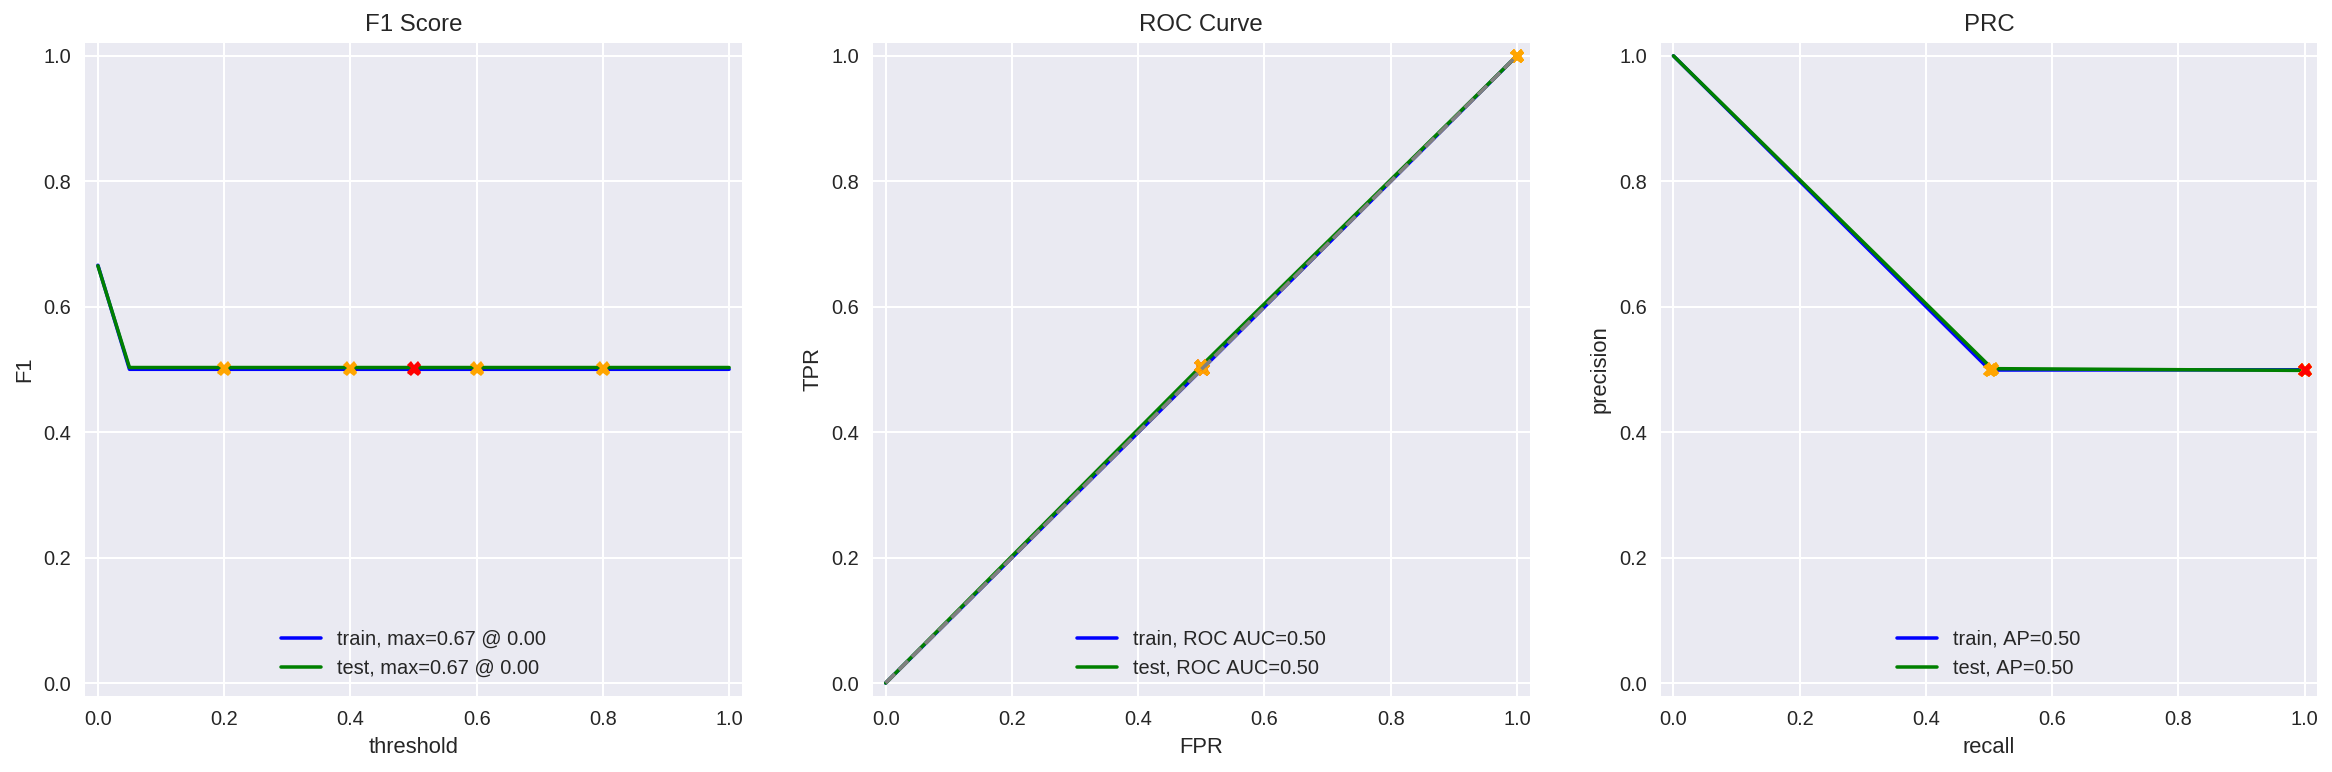

In [27]:
evaluate_model(dummy, tf_x_train, y_train, tf_x_test, y_test)

### Model 1  LR:

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lr = LogisticRegression(solver='liblinear',random_state=42)

In [30]:
lr.fit(tf_x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


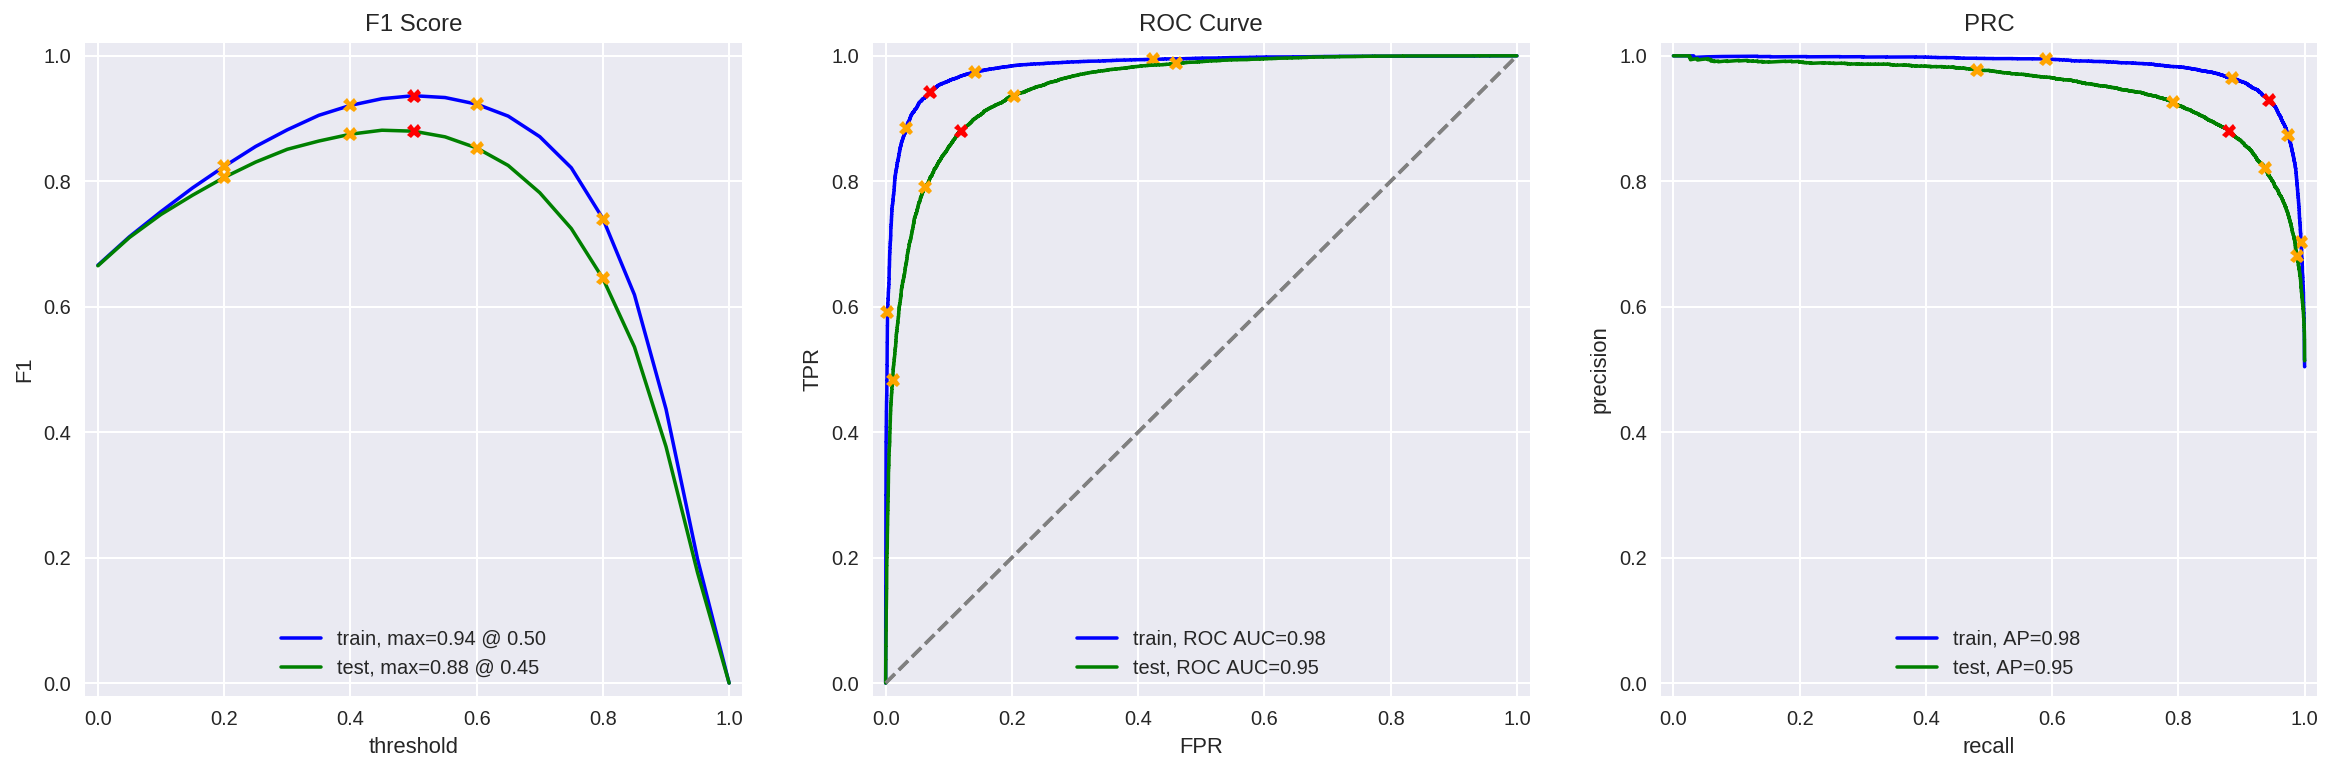

In [31]:
evaluate_model(lr, tf_x_train, y_train, tf_x_test, y_test)

#### Description:
- We see that simple LR provided us with F1 score of 0.88 for the test set, which surpasses our threshold for this task!

### Model 2 - CatBoost

In [32]:
from catboost import CatBoostClassifier

In [33]:
cb = CatBoostClassifier(loss_function='Logloss', eval_metric='F1',iterations=100,verbose=0)

In [34]:
cb.fit(tf_x_train, y_train)

          train  test
Accuracy   0.90  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


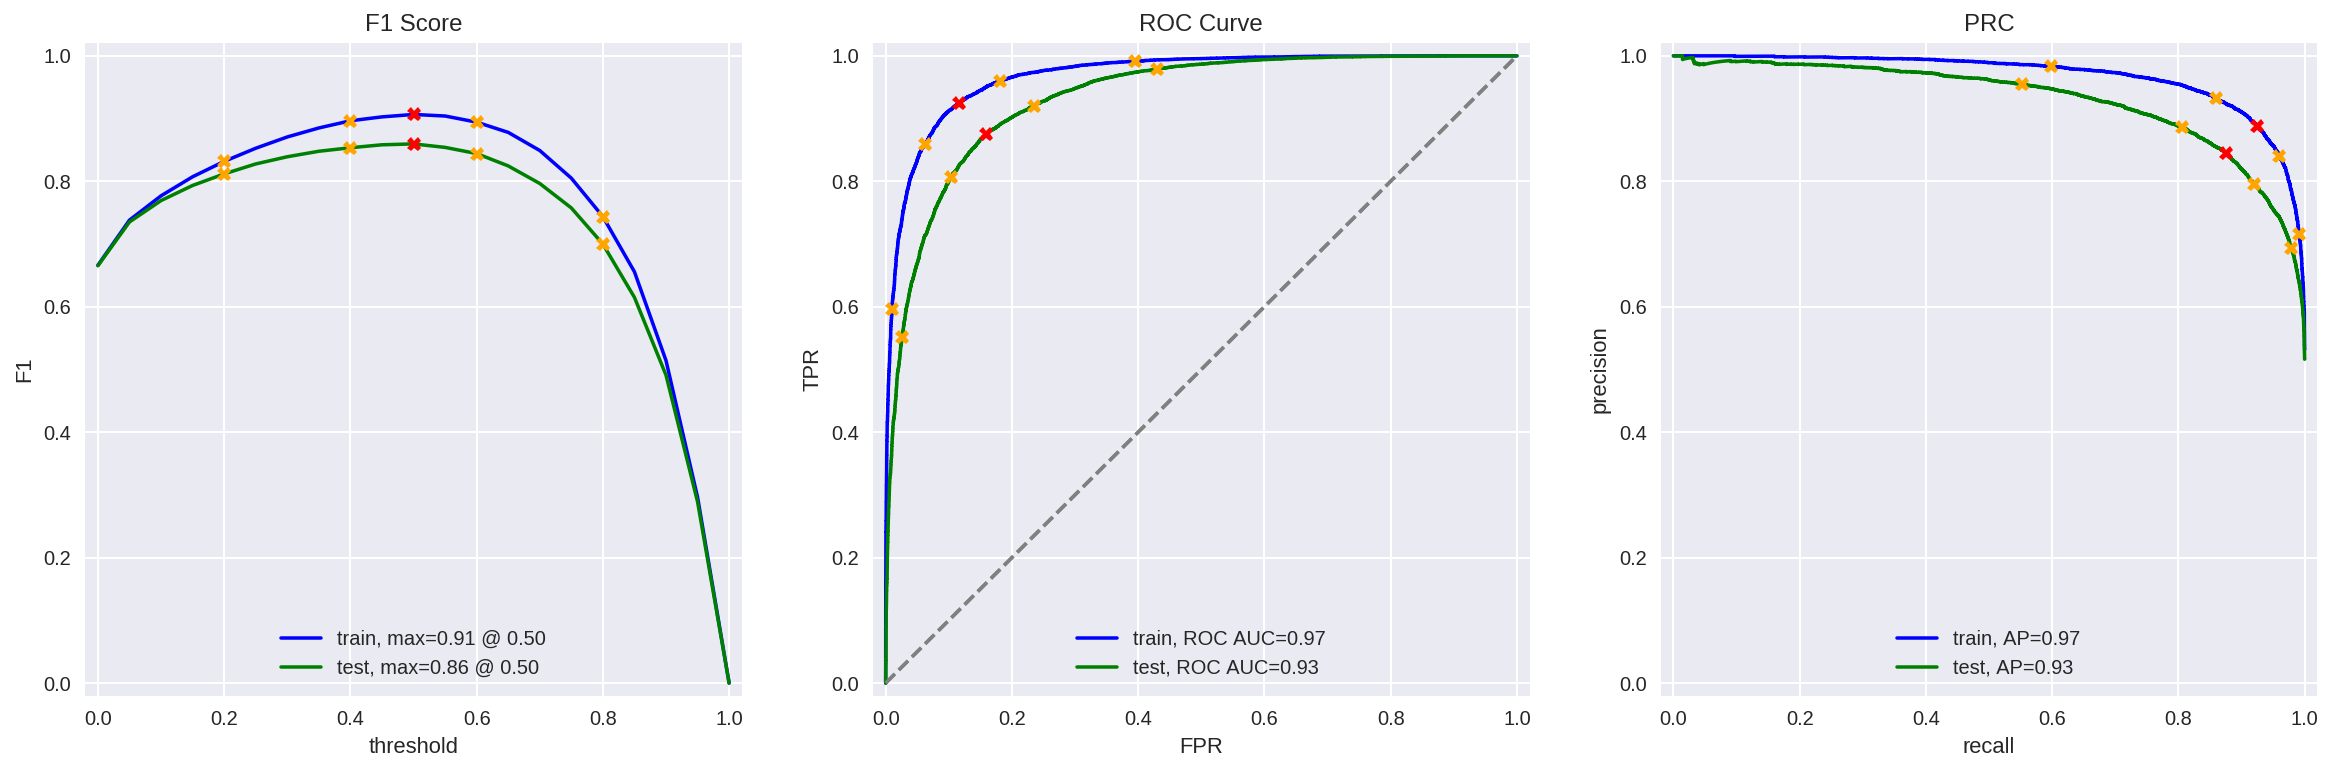

In [35]:
evaluate_model(cb, tf_x_train, y_train, tf_x_test, y_test)

### Model 3 - LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

In [37]:
lgbm = LGBMClassifier()

In [38]:
lgbm.fit(tf_x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


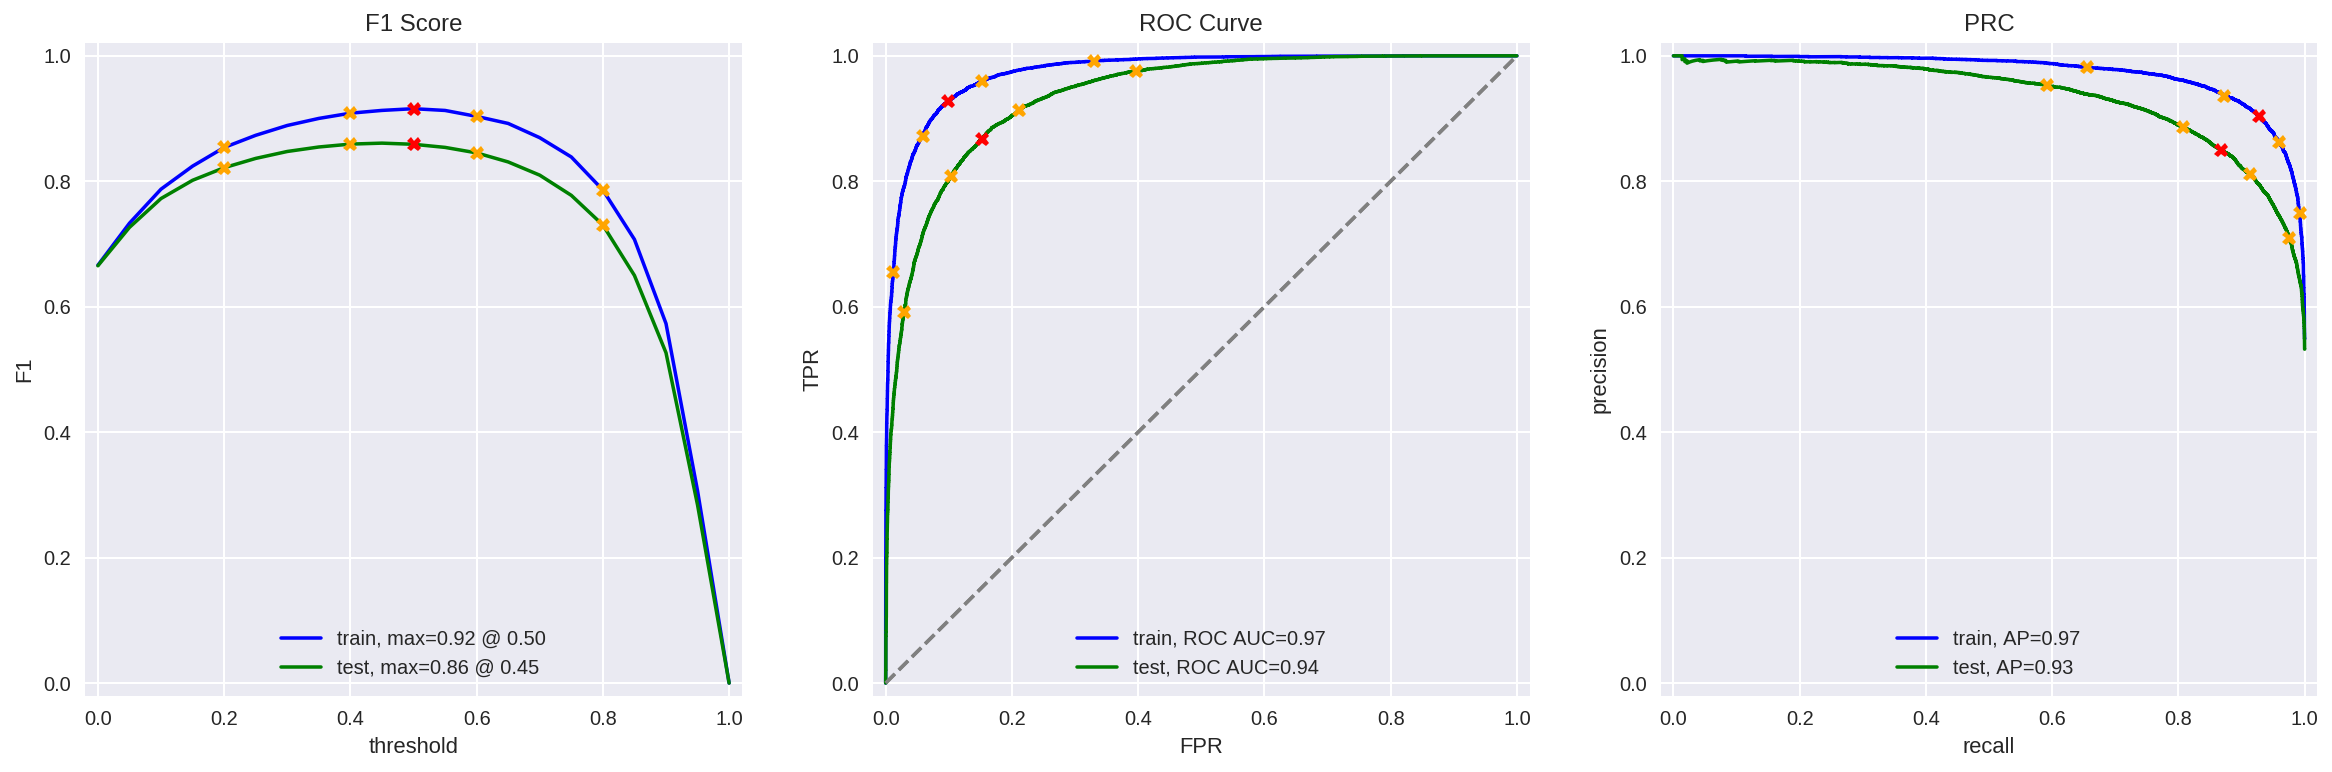

In [40]:
evaluate_model(lgbm, tf_x_train, y_train, tf_x_test, y_test)

We see that LGBM also surpassed our threshold with the value of 85, and we dont need further tuning.

###  Model 4 - RF Classifer:

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rfc = RandomForestClassifier(n_estimators = 100,max_depth=10,min_samples_leaf= 3) 

In [43]:
rfc.fit(tf_x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

          train  test
Accuracy   0.85  0.82
F1         0.86  0.83
APS        0.93  0.90
ROC AUC    0.93  0.90


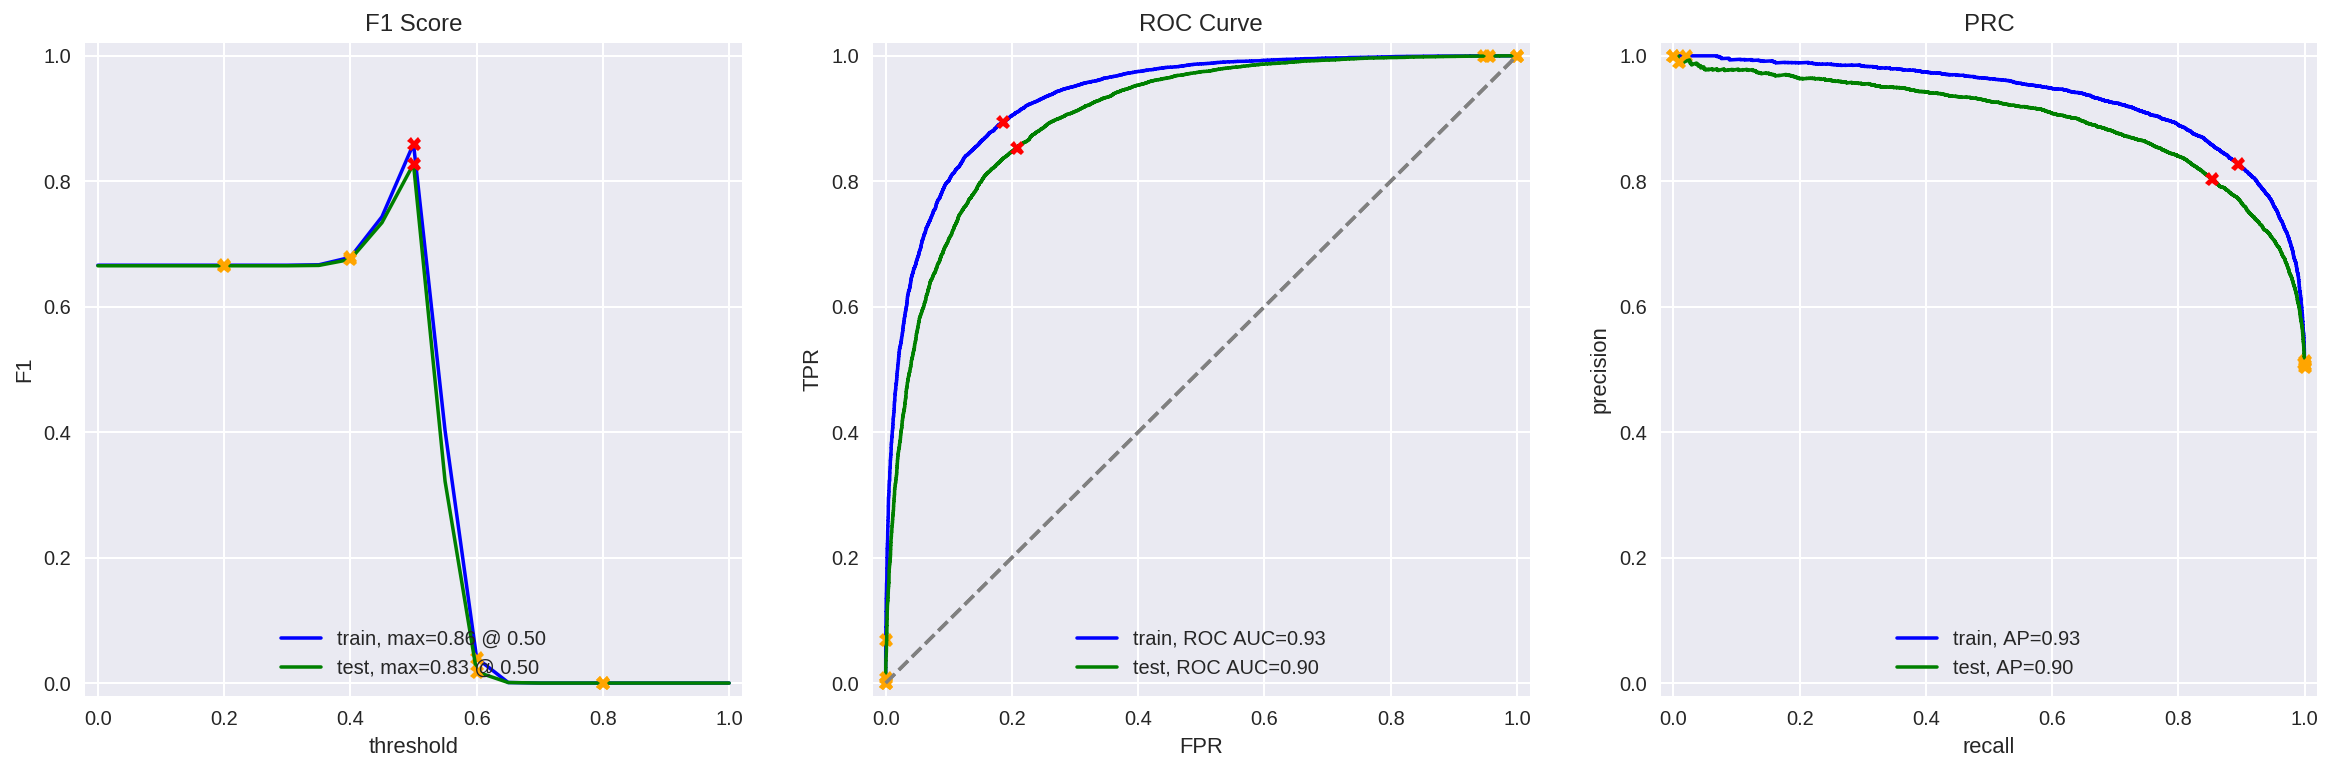

In [44]:
evaluate_model(rfc, tf_x_train, y_train, tf_x_test, y_test)

### Model 5- SVM:

In [45]:
from sklearn.svm import LinearSVC

In [46]:
clf = LinearSVC(random_state=42)

In [47]:
clf.fit(tf_x_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [48]:
from sklearn.metrics import f1_score
y_test_pred=clf.predict(tf_x_test)
print(f1_score(y_test, y_test_pred))

0.8672077361422899


### Conclusion:
- Without tuning any model, we have surpassed the threhold of 0.85 F1 score, with highest being Logistic Regression with 0.88


BERT application:

In [ ]:
# import torch
# import transformers


In [ ]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # text to padded ids of tokens along with their attention masks
    
#     # <put your code here to create ids_list and attention_mask_list>
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')
    
#     # gettings embeddings in batches

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # <put your code here to create attention_mask_batch
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [ ]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [49]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])


normalize_text(my_reviews, 'review', 'review_norm')

my_reviews.head()

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actor looked really old disinterested got...
4,I didn't expect the reboot to be so good! Writ...,nt expect reboot good writer really cared sour...


### LR

In [50]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  simply like kind movie
0.18:  well bored felt asleep middle movie
0.57:  really fascinated movie
0.13:  even actor looked really old disinterested got paid movie soulless cash grab
0.23:  nt expect reboot good writer really cared source material
0.51:  movie upside downside feel like overall decent flick could see going see
0.03:  rotten attempt comedy single joke land everyone act annoying loud even kid wo nt like
0.89:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### CatBoost

In [51]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = cb.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  simply like kind movie
0.50:  well bored felt asleep middle movie
0.57:  really fascinated movie
0.45:  even actor looked really old disinterested got paid movie soulless cash grab
0.54:  nt expect reboot good writer really cared source material
0.57:  movie upside downside feel like overall decent flick could see going see
0.23:  rotten attempt comedy single joke land everyone act annoying loud even kid wo nt like
0.66:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### LGBM

In [53]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  simply like kind movie
0.53:  well bored felt asleep middle movie
0.60:  really fascinated movie
0.37:  even actor looked really old disinterested got paid movie soulless cash grab
0.42:  nt expect reboot good writer really cared source material
0.53:  movie upside downside feel like overall decent flick could see going see
0.13:  rotten attempt comedy single joke land everyone act annoying loud even kid wo nt like
0.72:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### RF

In [54]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = rfc.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  simply like kind movie
0.52:  well bored felt asleep middle movie
0.52:  really fascinated movie
0.50:  even actor looked really old disinterested got paid movie soulless cash grab
0.52:  nt expect reboot good writer really cared source material
0.51:  movie upside downside feel like overall decent flick could see going see
0.46:  rotten attempt comedy single joke land everyone act annoying loud even kid wo nt like
0.52:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Conclusion:
- We see that on few reviews (small dataset), RF performed the worst,and LR still performed the best.
- If we would tune the gradient boosting based algorithms (catboost and LGBM), we should get even better results.

## Conclusions

- We have pre-procceced our data - removed spaces, non-alpha characters, spaces and lemmatized our words

- We have vectorized our procced data using TF-IDF vectorizer.

- We have surpassed the threshold of 0.85 F1 score with several models, with the best being Logistic Regression.

- On a small dataset and without hyper-parameters tuning, LR still performs the best.